In [9]:
!pip install tiingo
!pip install neuralprophet[live] --quiet
!pip install Pandas
!pip install numpy

Prep the data. Set up the baseline model.

In [10]:
import requests
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
from tiingo import TiingoClient
from neuralprophet import NeuralProphet, set_log_level
set_log_level("CRITICAL")
from neuralprophet import set_random_seed
set_random_seed(0)
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
from sklearn.metrics import mean_squared_error
import itertools

In [11]:
config = {
    'api_key': '4b9ae9d160a3f86078d365e94f9598f1ffc8a479',
    #'api_key': 'YOUR TTINGO API KEY HERE', 
     'session': True
}
client = TiingoClient(config)

In [12]:
ticker = 'btcusd'
frequency = '5min'
bars_ahead_forecast = 48
end_date = date.today()
history = client.get_crypto_price_history([ticker],
          endDate = end_date,
          resampleFreq = frequency)

In [13]:
df_hist = pd.DataFrame.from_dict(history[0]['priceData'])
df = pd.DataFrame(df_hist, columns=['date', 'close'])
df.rename(columns = {'date':'ds', 'close':'y'}, inplace = True)
df["ds"] = df["ds"].astype("datetime64[ns]")

In [14]:
# Default model with default values for these parameters. Same as m = NeuralProphet() 

m = NeuralProphet(
    n_changepoints = 5,
    changepoints_range = 0.80,
    trend_reg=0,      
)
metrics = m.fit(df)


WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

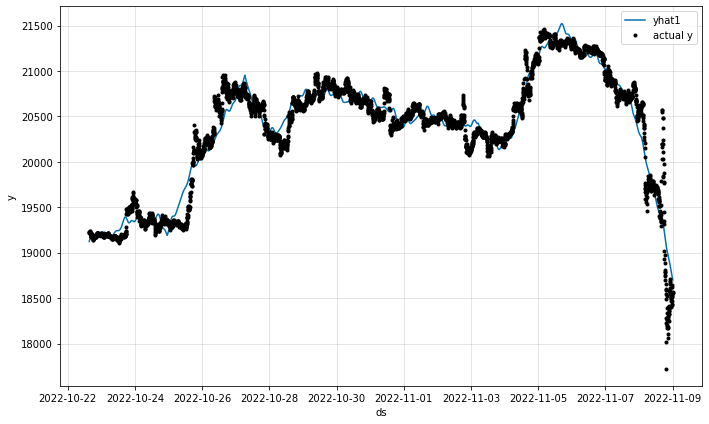

In [18]:
# Once the model is fitted, we can make predictions using the fitted model. Here we are predicting only in-sample over our data 
#to evaluate the model fit.

predicted = m.predict(df)
forecast = m.predict(df)
forecasts_plot = m.plot(forecast)

In [19]:
# Mean Absolute Percentge Error (MAPE) the closer to 0 the better. 
def mape(y_a, y_f):
    return np.mean(np.abs((y_a - y_f) / y_a))

In [20]:
# Display the MAPE for this model. < 5% is acceptable
y_actual = forecast.y
y_forecast = forecast.yhat1
print("MEAN ABSOLUTE PERCENTAGE ERROR FOR THIS MODEL:" + " " + "{:.1%}".format(mape(y_actual, y_forecast)))

MEAN ABSOLUTE PERCENTAGE ERROR FOR THIS MODEL: 0.6%


Validate the baseline model

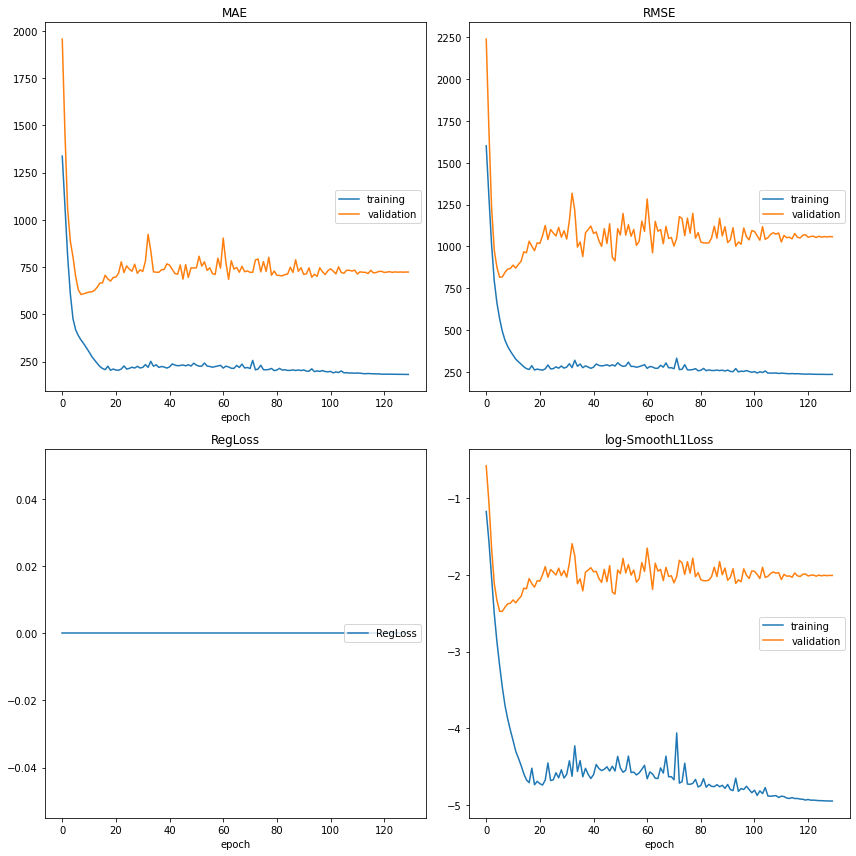

MAE
	training         	 (min:  182.219, max: 1336.742, cur:  182.219)
	validation       	 (min:  604.856, max: 1955.395, cur:  723.693)
RMSE
	training         	 (min:  235.049, max: 1600.932, cur:  235.340)
	validation       	 (min:  815.654, max: 2238.257, cur: 1058.172)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -4.948, max:   -1.176, cur:   -4.948)
	validation       	 (min:   -2.476, max:   -0.580, cur:   -2.009)


In [21]:
m = NeuralProphet(
    n_changepoints = 5,
    changepoints_range = 0.80,
    trend_reg = 0,      
)

df_train, df_test = m.split_df(df, valid_p=0.2)
metrics = m.fit(df_train, validation_df=df_test, progress="plot-all")

We are ready to optimize!

In [22]:
#HYPERPARAMETER TUNING STAGE 1
#You have evaluated the default model and now you can try to improve the model by optimizing the changepoints parameters. 
#First, we set up the search grid and set some values for the parameters we want to optimize.

In [23]:
# Parameter Options
param_grid = {      
    'n_changepoints': [50, 90, 120, 150, 180],
    'changepoints_range': [0.95, 0.99, 0.995, 0.999],    
}

In [24]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []  # Store the RMSEs for each params here

In [25]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = NeuralProphet(**params, trend_reg=0)   
    metrics2 = m.fit(df=df_train, validation_df=df_test, freq="H")
    results.append(dict({"RMSE_val": metrics2['RMSE_val'].min(), "RMSE_train": metrics2['RMSE'][metrics2['RMSE_val'].idxmin()], "epoch_number": metrics2['RMSE_val'].idxmin()}, **params))

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [26]:
#Show the results in a table sorted by RMSE from lowest (best) to highest on the validation data.

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=["RMSE_val"] , ascending = True) 
df_results

,RMSE_val,RMSE_train,epoch_number,n_changepoints,changepoints_range
3,482.398499,113.516970,48,50,0.999
2,492.581116,119.725267,70,50,0.995
6,519.326904,419.274719,17,90,0.995
5,528.929993,203.017295,55,90,0.990
13,546.445618,160.642180,30,150,0.990
9,611.575439,196.368190,55,120,0.990
17,619.767273,125.106025,42,180,0.990
1,637.329468,202.323760,58,50,0.990
11,807.807434,632.666764,5,120,0.999
10,809.200256,154.276058,26,120,0.995


In [27]:
#HYPERPARAMETER TUNING STAGE 2 
#This step is identical to STAGE 1 with a more focused range of variables based on the info we got from STAGE 1. 
#50 changepoints is the most prevalent value in the top RMSE_val scores so we will try higher and lower values 
#on either side of 50 so see if we can continue to improve RMSE_val.

In [28]:
# Parameter Options
param_grid = {      
    'n_changepoints': [46, 48, 52, 54],
    'changepoints_range': [0.99, 0.995],    
}

In [29]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results2 = []  # Store the RMSEs for each params here

In [30]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = NeuralProphet(**params, trend_reg=0)   
    metrics3 = m.fit(df=df_train, validation_df=df_test, freq="H")
    results2.append(dict({"RMSE_val": metrics3['RMSE_val'].min(), "RMSE_train": metrics3['RMSE'][metrics3['RMSE_val'].idxmin()], "epoch_number": metrics3['RMSE_val'].idxmin()}, **params))

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [31]:
# Show the results table
df_results2 = pd.DataFrame(results2)
df_results2 = df_results2.sort_values(by=["RMSE_val"] , ascending = True) 
df_results2

,RMSE_val,RMSE_train,epoch_number,n_changepoints,changepoints_range
3,487.604797,125.955393,44,48,0.995
5,496.180786,171.370166,51,52,0.995
7,507.812561,135.510020,53,54,0.995
6,558.898438,119.077701,63,54,0.990
1,575.739868,136.683836,90,46,0.995
4,601.922302,142.069372,59,52,0.990
2,690.740967,180.721355,32,48,0.990
0,734.372437,142.164543,53,46,0.990


In [32]:
#Ready to make 4 hour forecast from the 5 minute data (60/5) * 4 = 48

In [33]:
m = NeuralProphet(
    n_changepoints = 54,
    changepoints_range = 0.995,
    trend_reg = 0,  
    epochs = 80,
)
bars_ahead_forecast = 48

In [34]:
metrics = m.fit(df, freq='auto', minimal = True)
future = m.make_future_dataframe(df, periods=int(bars_ahead_forecast), n_historic_predictions=len(df))
forecast = m.predict(future)
predict = forecast.tail(200)

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\df_utils.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)

  df = df.append(df_end_to_append)



In [35]:
# Include 1 and 2 standard deviation lines in the plot
std = predict['yhat1'].std()
upper2 = predict['yhat1'] + (2 * std)  
lower2 = predict['yhat1'] - (2 * std)
upper1 = predict['yhat1'] + (1 * std)  
lower1 = predict['yhat1'] - (1 * std)
actual = predict['y']
fcst = predict['yhat1']
dates = predict['ds']

<AxesSubplot:title={'center':'btcusd 5min'}, xlabel='date'>

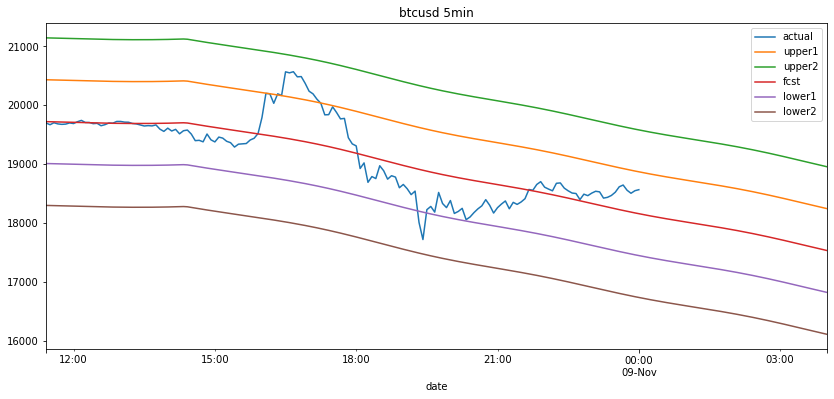

In [36]:
df1 = pd.DataFrame({'date': dates, 'actual': actual, 'fcst':fcst, 'upper2': upper2, 'upper1':upper1, 'lower2':lower2, 'lower1':lower1})
df1.plot(x='date', y=['actual', 'upper1', 'upper2', 'fcst', 'lower1', 'lower2'], figsize=(14,6), title = ticker + ' ' + frequency)

In [ ]:
fig_forecast = m.plot(forecast, figsize=(12,6), ylabel=ticker)